## __Covid Deaths Forecasting Prediction in Germany__

## TensorFlow Keras LSTM RNN Multivariate Time Series Forecasting

Data Source: https://www.kaggle.com/headsortails/covid19-tracking-germany

__Tableau Dashboard__ created to interact with dataset: https://public.tableau.com/views/CovidDeathsinGermanybyStateandAgeGroup/CovidAnalysisinGermany?:language=en-US&:display_count=n&:origin=viz_share_link

### Import Libraries

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

### Data preprocessing

In [6]:
df_vaccines = pd.read_csv("covid_de_vaccines.csv")

In [7]:
df_vaccines.head()

,date,doses,doses_first,doses_second,pfizer_cumul,moderna_cumul,astrazeneca_cumul,persons_first_cumul,persons_full_cumul
0,2020-12-27,24366,24355,11,24357,8,1,24355,11
1,2020-12-28,18090,18026,64,42445,9,2,42381,75
2,2020-12-29,50697,50044,652,93141,9,3,92425,727
3,2020-12-30,64113,64080,33,157253,10,3,156505,760
4,2020-12-31,50008,49921,87,207258,12,4,206426,847


In [9]:
df_vaccines.tail()

,date,doses,doses_first,doses_second,pfizer_cumul,moderna_cumul,astrazeneca_cumul,persons_first_cumul,persons_full_cumul
376,2022-01-07,734761,54070,110611,113100354,24031075,12745880,62014710,59715914
377,2022-01-08,494264,43148,76715,113384682,24240057,12745990,62057858,59793473
378,2022-01-09,173341,17385,31930,113491760,24305778,12746286,62075243,59825649
379,2022-01-10,521021,34665,75459,113787666,24529877,12746298,62109908,59902112
380,2022-01-11,713692,48541,106899,114205666,24823436,12746744,62158449,60010698


In [10]:
df_vaccines.shape

(381, 9)

In [11]:
df_vaccines.isnull().values.any()

False

In [12]:
df_vaccines.isnull().sum().sum()

0

In [13]:
df_vaccines.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
doses,381.0,4.077846e+05,3.467799e+05,13892.0,148122.0,279038.0,599019.0,1634921.0
doses_first,381.0,1.631455e+05,1.795643e+05,2041.0,54070.0,92871.0,195794.0,1058697.0
doses_second,381.0,1.480856e+05,1.721141e+05,9.0,51875.0,76492.0,161492.0,880825.0
pfizer_cumul,381.0,5.169582e+07,3.718616e+07,24357.0,10701094.0,57818984.0,83541641.0,114205666.0
moderna_cumul,381.0,6.588744e+06,6.013113e+06,8.0,770710.0,6954070.0,9698664.0,24823436.0
astrazeneca_cumul,381.0,8.413532e+06,5.127135e+06,1.0,3081240.0,11910712.0,12713391.0,12746744.0
persons_first_cumul,381.0,3.666690e+07,2.287440e+07,24355.0,10207773.0,47843152.0,57083260.0,62158449.0
persons_full_cumul,381.0,2.993456e+07,2.357273e+07,11.0,4345416.0,32928752.0,54321980.0,60010698.0


In [14]:
df_vacc_filtered = df_vaccines[["date", "persons_first_cumul", "persons_full_cumul"]]

In [17]:
df_vacc_filtered["vacc_first_diff"] = df_vacc_filtered.persons_first_cumul - df_vacc_filtered.persons_full_cumul

<ipython-input-17-c3923cafbc41>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vacc_filtered["vacc_first_diff"] = df_vacc_filtered.persons_first_cumul - df_vacc_filtered.persons_full_cumul


In [18]:
df_vacc_filtered.set_index("date", drop=True, inplace=True)

In [13]:
df_vacc_filtered.astype({'persons_first_cumul': 'int64', "persons_full_cumul" : "int64"}).dtypes

persons_first_cumul    int64
persons_full_cumul     int64
vacc_first_diff        int64
dtype: object

In [20]:
df_vacc_filtered

,persons_first_cumul,persons_full_cumul,vacc_first_diff
date,,,
2020-12-27,24355,11,24344
2020-12-28,42381,75,42306
2020-12-29,92425,727,91698
2020-12-30,156505,760,155745
2020-12-31,206426,847,205579
...,...,...,...
2022-01-07,62014710,59715914,2298796
2022-01-08,62057858,59793473,2264385
2022-01-09,62075243,59825649,2249594


In [21]:
df_demographics = pd.read_csv("demographics_de.csv")

In [22]:
df_demographics["Country"] = "Germany"

In [24]:
df_demographics

,state,gender,age_group,population,Country
0,Baden-Wuerttemberg,female,00-04,261674,Germany
1,Baden-Wuerttemberg,female,05-14,490822,Germany
2,Baden-Wuerttemberg,female,15-34,1293488,Germany
3,Baden-Wuerttemberg,female,35-59,1919649,Germany
4,Baden-Wuerttemberg,female,60-79,1182736,Germany
...,...,...,...,...,...
187,Thueringen,male,05-14,92545,Germany
188,Thueringen,male,15-34,214553,Germany
189,Thueringen,male,35-59,384822,Germany
190,Thueringen,male,60-79,264189,Germany


In [25]:
#Data for Tableau
df_demographics.to_csv('demographics_de2.csv', index=False)

In [26]:
#no null values
df_demographics.isnull().isna().values.any()

False

In [27]:
df_demographics.isnull().isna().sum().sum()

0

In [28]:
df_demograph_filtered = df_demographics[["population"]]

In [29]:
df_demograph_filtered = df_demograph_filtered.sum()

In [30]:
df_demograph_filtered

population    83019213
dtype: int64

In [31]:
df_demo_age_filtered = df_demographics[["age_group","population"]]

In [32]:
df_demo_age_filtered.head(5)

,age_group,population
0,00-04,261674
1,05-14,490822
2,15-34,1293488
3,35-59,1919649
4,60-79,1182736


In [33]:
df_demo_age_filtered.nunique()

age_group       6
population    192
dtype: int64

In [34]:
df_demo_age_filtered = df_demo_age_filtered.groupby(by="age_group")["population"].sum()

In [35]:
df_demo_age_filtered.head(10)

age_group
00-04     3926397
05-14     7364418
15-34    19213113
35-59    29137839
60-79    17988340
80-99     5389106
Name: population, dtype: int64

In [36]:
df_cases = pd.read_csv("covid_de.csv")

In [39]:
df_cases

,state,county,age_group,gender,date,cases,deaths,recovered
0,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-03-27,1,0,1
1,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-03-28,1,0,1
2,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-04-03,1,0,1
3,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-10-18,1,0,1
4,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-10-22,1,0,1
...,...,...,...,...,...,...,...,...
1412789,Thueringen,SK Weimar,80-99,M,2022-01-03,1,0,0
1412790,Thueringen,SK Weimar,NaN,F,2021-12-01,1,0,1
1412791,Thueringen,SK Weimar,NaN,F,2021-12-11,1,0,1
1412792,Thueringen,SK Weimar,NaN,F,2021-12-23,1,0,0


In [41]:
df_cases["Country"]="Germany"

In [42]:
df_cases.sort_values(by=["date"])

,state,county,age_group,gender,date,cases,deaths,recovered,Country
908823,Nordrhein-Westfalen,LK Maerkischer Kreis,80-99,M,2020-01-02,1,0,1,Germany
401478,Bayern,LK Weilheim-Schongau,35-59,M,2020-01-10,1,0,1,Germany
82979,Baden-Wuerttemberg,LK Ortenaukreis,35-59,F,2020-01-20,1,0,1,Germany
1212960,Saarland,LK Stadtverband Saarbruecken,80-99,M,2020-01-23,1,0,1,Germany
384735,Bayern,LK Starnberg,35-59,M,2020-01-28,1,0,1,Germany
...,...,...,...,...,...,...,...,...,...
1088295,Nordrhein-Westfalen,SK Wuppertal,NaN,M,2022-01-11,2,0,0,Germany
832065,Niedersachsen,Region Hannover,35-59,NaN,2022-01-11,1,0,0,Germany
164675,Baden-Wuerttemberg,SK Pforzheim,00-04,F,2022-01-11,1,0,0,Germany
1274318,Sachsen-Anhalt,LK Burgenlandkreis,00-04,F,2022-01-11,3,0,0,Germany


In [43]:
df_cases_age_filtered = df_cases[["date","age_group","cases","deaths","recovered"]]

In [44]:
df_cases_filtered = df_cases[["date","cases","deaths","recovered"]]

In [45]:
df_cases_filtered.head()

,date,cases,deaths,recovered
0,2020-03-27,1,0,1
1,2020-03-28,1,0,1
2,2020-04-03,1,0,1
3,2020-10-18,1,0,1
4,2020-10-22,1,0,1


In [46]:
df_cases_filtered.isnull().isna().sum().sum()

0

In [47]:
df_cases_filtered = df_cases_filtered.sort_values(by="date")
df_cases_filtered.head()

,date,cases,deaths,recovered
908823,2020-01-02,1,0,1
401478,2020-01-10,1,0,1
82979,2020-01-20,1,0,1
1212960,2020-01-23,1,0,1
384735,2020-01-28,1,0,1


In [48]:
df_cases_filtered = df_cases_filtered.groupby("date").sum()

In [38]:
df_cases_filtered.head()

,cases,deaths,recovered
date,,,
2020-01-02,1,0,1
2020-01-10,1,0,1
2020-01-20,1,0,1
2020-01-23,1,0,1
2020-01-28,2,0,2


In [49]:
df_cases_age_filtered = df_cases[["date", "age_group", "cases", "deaths", "recovered"]]

In [50]:
df_cases_age_filtered.head()

,date,age_group,cases,deaths,recovered
0,2020-03-27,00-04,1,0,1
1,2020-03-28,00-04,1,0,1
2,2020-04-03,00-04,1,0,1
3,2020-10-18,00-04,1,0,1
4,2020-10-22,00-04,1,0,1


In [52]:
#country added for Tableau visualization
df_cases.to_csv("covid_de2.csv", index=False)

In [53]:
#based on the data and checking the lack of level of granularity in vaccines dataset we can either
#delete genders and age group of our datasets as we do not have data for that granularity in our vaccines dataset
#or if we want to predict cases and deaths also by gender and age, we need to "suppose" data and complement our vaccines dataset


### Joining important features from different dataframes

In [54]:
df_vacc_filtered

,persons_first_cumul,persons_full_cumul,vacc_first_diff
date,,,
2020-12-27,24355,11,24344
2020-12-28,42381,75,42306
2020-12-29,92425,727,91698
2020-12-30,156505,760,155745
2020-12-31,206426,847,205579
...,...,...,...
2022-01-07,62014710,59715914,2298796
2022-01-08,62057858,59793473,2264385
2022-01-09,62075243,59825649,2249594


In [55]:
df_vacc_filtered.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 381 entries, 2020-12-27 to 2022-01-11
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   persons_first_cumul  381 non-null    int64
 1   persons_full_cumul   381 non-null    int64
 2   vacc_first_diff      381 non-null    int64
dtypes: int64(3)
memory usage: 11.9+ KB


In [57]:
df_cases_filtered

,cases,deaths,recovered
date,,,
2020-01-02,1,0,1
2020-01-10,1,0,1
2020-01-20,1,0,1
2020-01-23,1,0,1
2020-01-28,2,0,2
...,...,...,...
2022-01-07,54327,14,523
2022-01-08,35603,9,203
2022-01-09,22116,5,90


In [58]:
df_cases_merged = pd.merge(df_cases_filtered, df_vacc_filtered, on='date', how='left')
df_cases_merged

,cases,deaths,recovered,persons_first_cumul,persons_full_cumul,vacc_first_diff
date,,,,,,
2020-01-02,1,0,1,NaN,NaN,NaN
2020-01-10,1,0,1,NaN,NaN,NaN
2020-01-20,1,0,1,NaN,NaN,NaN
2020-01-23,1,0,1,NaN,NaN,NaN
2020-01-28,2,0,2,NaN,NaN,NaN
...,...,...,...,...,...,...
2022-01-07,54327,14,523,62014710.0,59715914.0,2298796.0
2022-01-08,35603,9,203,62057858.0,59793473.0,2264385.0
2022-01-09,22116,5,90,62075243.0,59825649.0,2249594.0


In [59]:
df_cases_merged.fillna(value=0, inplace=True)
#df_cases_merged["population"] = 83019213
#df_cases_merged

In [60]:
df_cases_merged=df_cases_merged.astype({"persons_first_cumul":"int64"})
df_cases_merged=df_cases_merged.astype({"persons_full_cumul":"int64"})
df_cases_merged=df_cases_merged.astype({"vacc_first_diff":"int64"})

In [61]:
df_cases_merged

,cases,deaths,recovered,persons_first_cumul,persons_full_cumul,vacc_first_diff
date,,,,,,
2020-01-02,1,0,1,0,0,0
2020-01-10,1,0,1,0,0,0
2020-01-20,1,0,1,0,0,0
2020-01-23,1,0,1,0,0,0
2020-01-28,2,0,2,0,0,0
...,...,...,...,...,...,...
2022-01-07,54327,14,523,62014710,59715914,2298796
2022-01-08,35603,9,203,62057858,59793473,2264385
2022-01-09,22116,5,90,62075243,59825649,2249594


In [62]:
df_cases_merged.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 705 entries, 2020-01-02 to 2022-01-11
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   cases                705 non-null    int64
 1   deaths               705 non-null    int64
 2   recovered            705 non-null    int64
 3   persons_first_cumul  705 non-null    int64
 4   persons_full_cumul   705 non-null    int64
 5   vacc_first_diff      705 non-null    int64
dtypes: int64(6)
memory usage: 38.6+ KB


In [63]:
df_cases_merged

,cases,deaths,recovered,persons_first_cumul,persons_full_cumul,vacc_first_diff
date,,,,,,
2020-01-02,1,0,1,0,0,0
2020-01-10,1,0,1,0,0,0
2020-01-20,1,0,1,0,0,0
2020-01-23,1,0,1,0,0,0
2020-01-28,2,0,2,0,0,0
...,...,...,...,...,...,...
2022-01-07,54327,14,523,62014710,59715914,2298796
2022-01-08,35603,9,203,62057858,59793473,2264385
2022-01-09,22116,5,90,62075243,59825649,2249594


In [64]:
df_cases_merged.corr()

,cases,deaths,recovered,persons_first_cumul,persons_full_cumul,vacc_first_diff
cases,1.000000,0.519689,0.902508,0.416704,0.463302,-0.041737
deaths,0.519689,1.000000,0.589178,-0.169751,-0.135091,-0.192633
recovered,0.902508,0.589178,1.000000,0.329947,0.365051,-0.026042
persons_first_cumul,0.416704,-0.169751,0.329947,1.000000,0.973280,0.441282
persons_full_cumul,0.463302,-0.135091,0.365051,0.973280,1.000000,0.223434
vacc_first_diff,-0.041737,-0.192633,-0.026042,0.441282,0.223434,1.000000


In [104]:
#to detect cases we will not use deaths and recovered
#check later if deaths and recovered can affect positively the model
df_cases_t1 = df_cases_merged[["deaths", "cases", "persons_first_cumul", "persons_full_cumul"]]
df = df_cases_merged[["deaths", "cases", "vacc_first_diff", "persons_full_cumul", "recovered"]]
#df_cases_t1 = df_cases_merged[["cases", "persons_first_cumul"]]
#df = df_cases_merged[["cases", "deaths", "persons_first_cumul", "persons_full_cumul"]]
#df = df_cases_t1[df_cases_t1['persons_first_cumul'] != 0]

In [105]:
df.corr()

,deaths,cases,vacc_first_diff,persons_full_cumul,recovered
deaths,1.000000,0.519689,-0.192633,-0.135091,0.589178
cases,0.519689,1.000000,-0.041737,0.463302,0.902508
vacc_first_diff,-0.192633,-0.041737,1.000000,0.223434,-0.026042
persons_full_cumul,-0.135091,0.463302,0.223434,1.000000,0.365051
recovered,0.589178,0.902508,-0.026042,0.365051,1.000000


In [106]:
#think to consider to analyze the probability of geting covid depending your age, where you live and vaccination status

In [107]:
df.index = pd.to_datetime(df.index)

In [108]:
df.index

DatetimeIndex(['2020-01-02', '2020-01-10', '2020-01-20', '2020-01-23',
               '2020-01-28', '2020-01-29', '2020-01-31', '2020-02-01',
               '2020-02-03', '2020-02-04',
               ...
               '2022-01-02', '2022-01-03', '2022-01-04', '2022-01-05',
               '2022-01-06', '2022-01-07', '2022-01-08', '2022-01-09',
               '2022-01-10', '2022-01-11'],
              dtype='datetime64[ns]', name='date', length=705, freq=None)

### Amount of Deaths since the beginning of the pandemic

<AxesSubplot:xlabel='date', ylabel='deaths'>

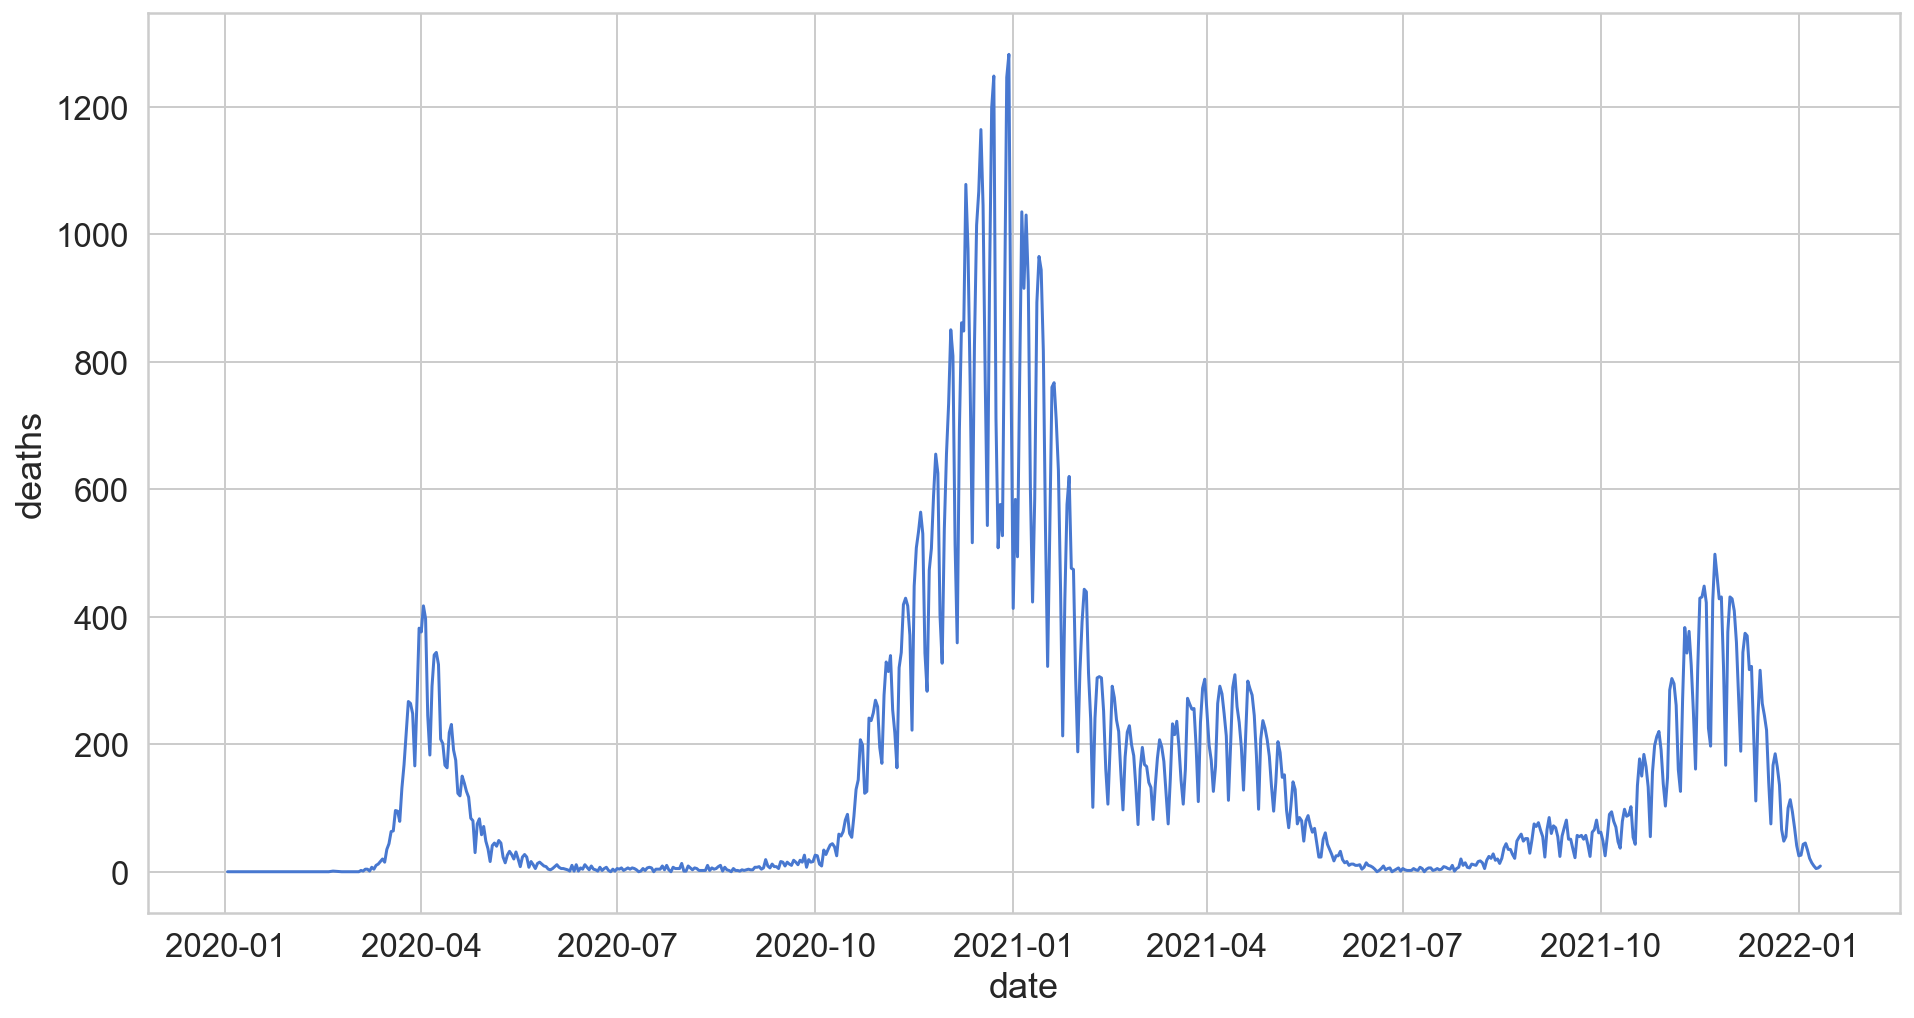

In [109]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 15.7,8.27

sns.lineplot(x=df.index, y="deaths", data = df, sizes=100)

<AxesSubplot:xlabel='date', ylabel='cases'>

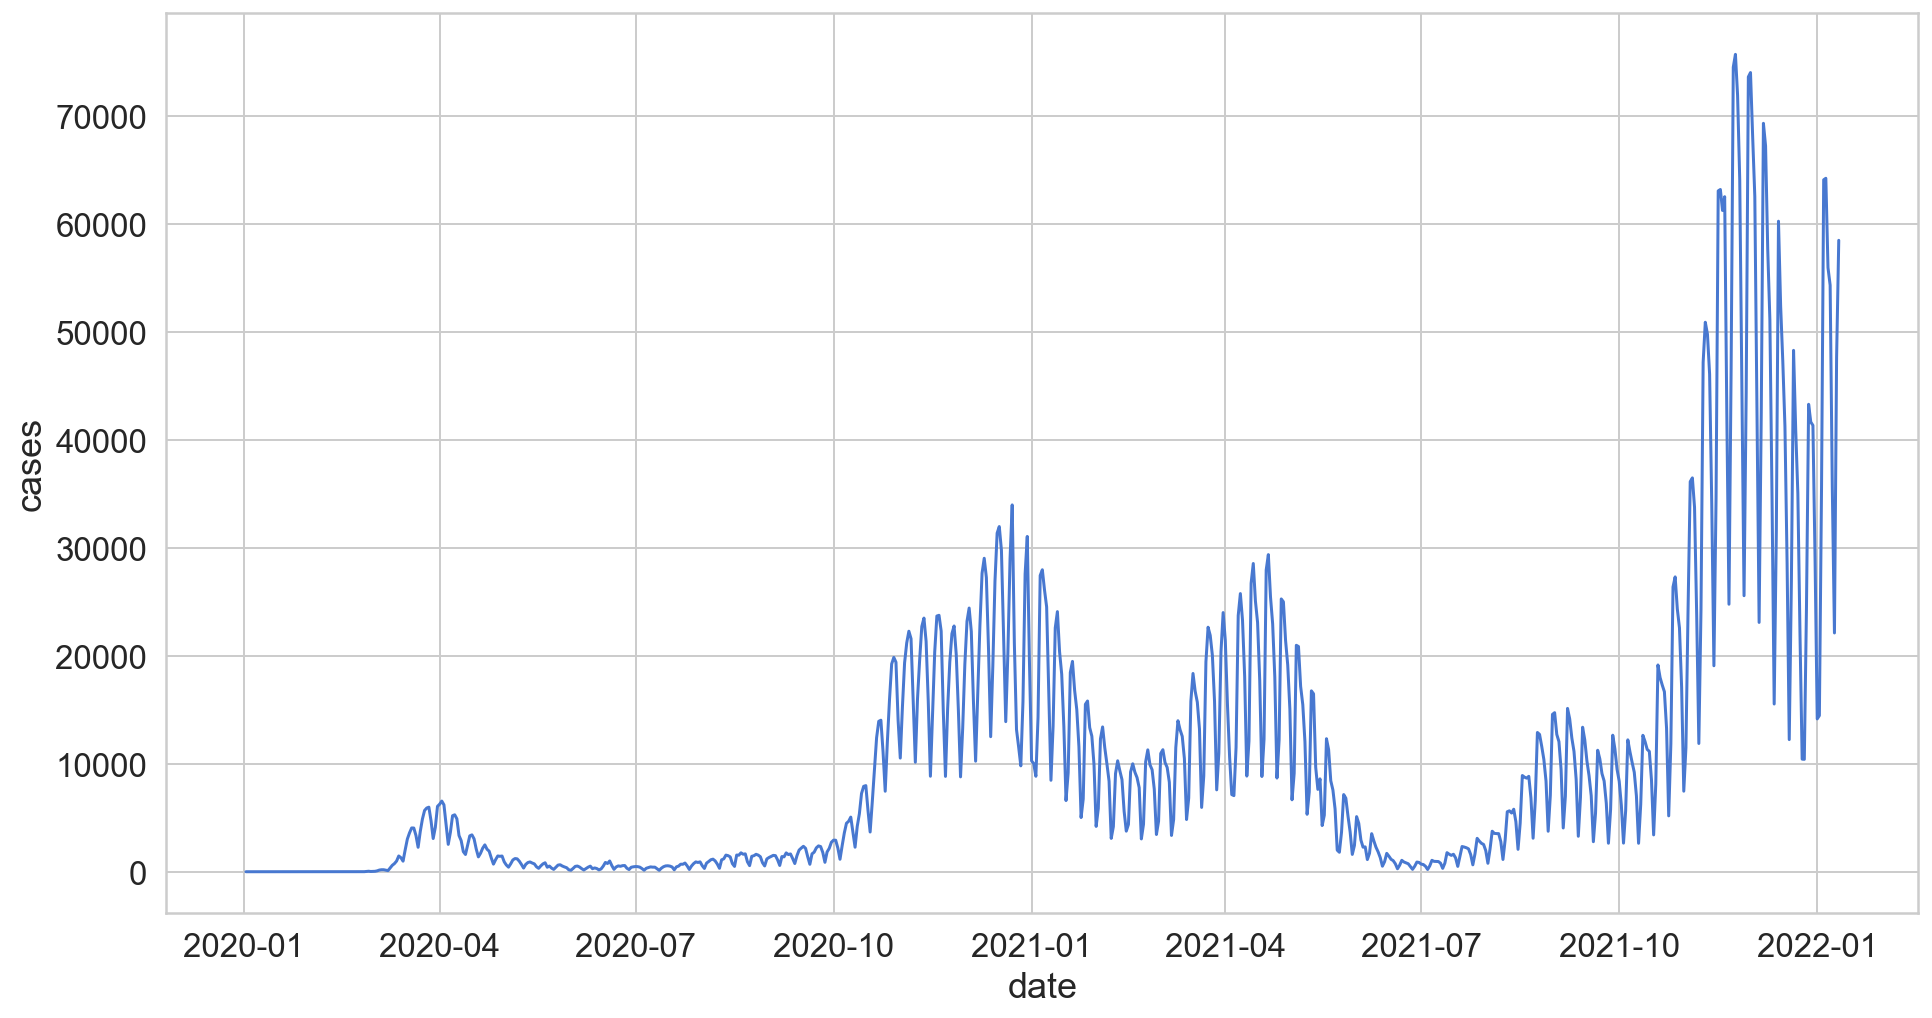

In [110]:
sns.lineplot(x=df.index, y="cases", data = df, sizes=100)

<AxesSubplot:xlabel='date', ylabel='persons_full_cumul'>

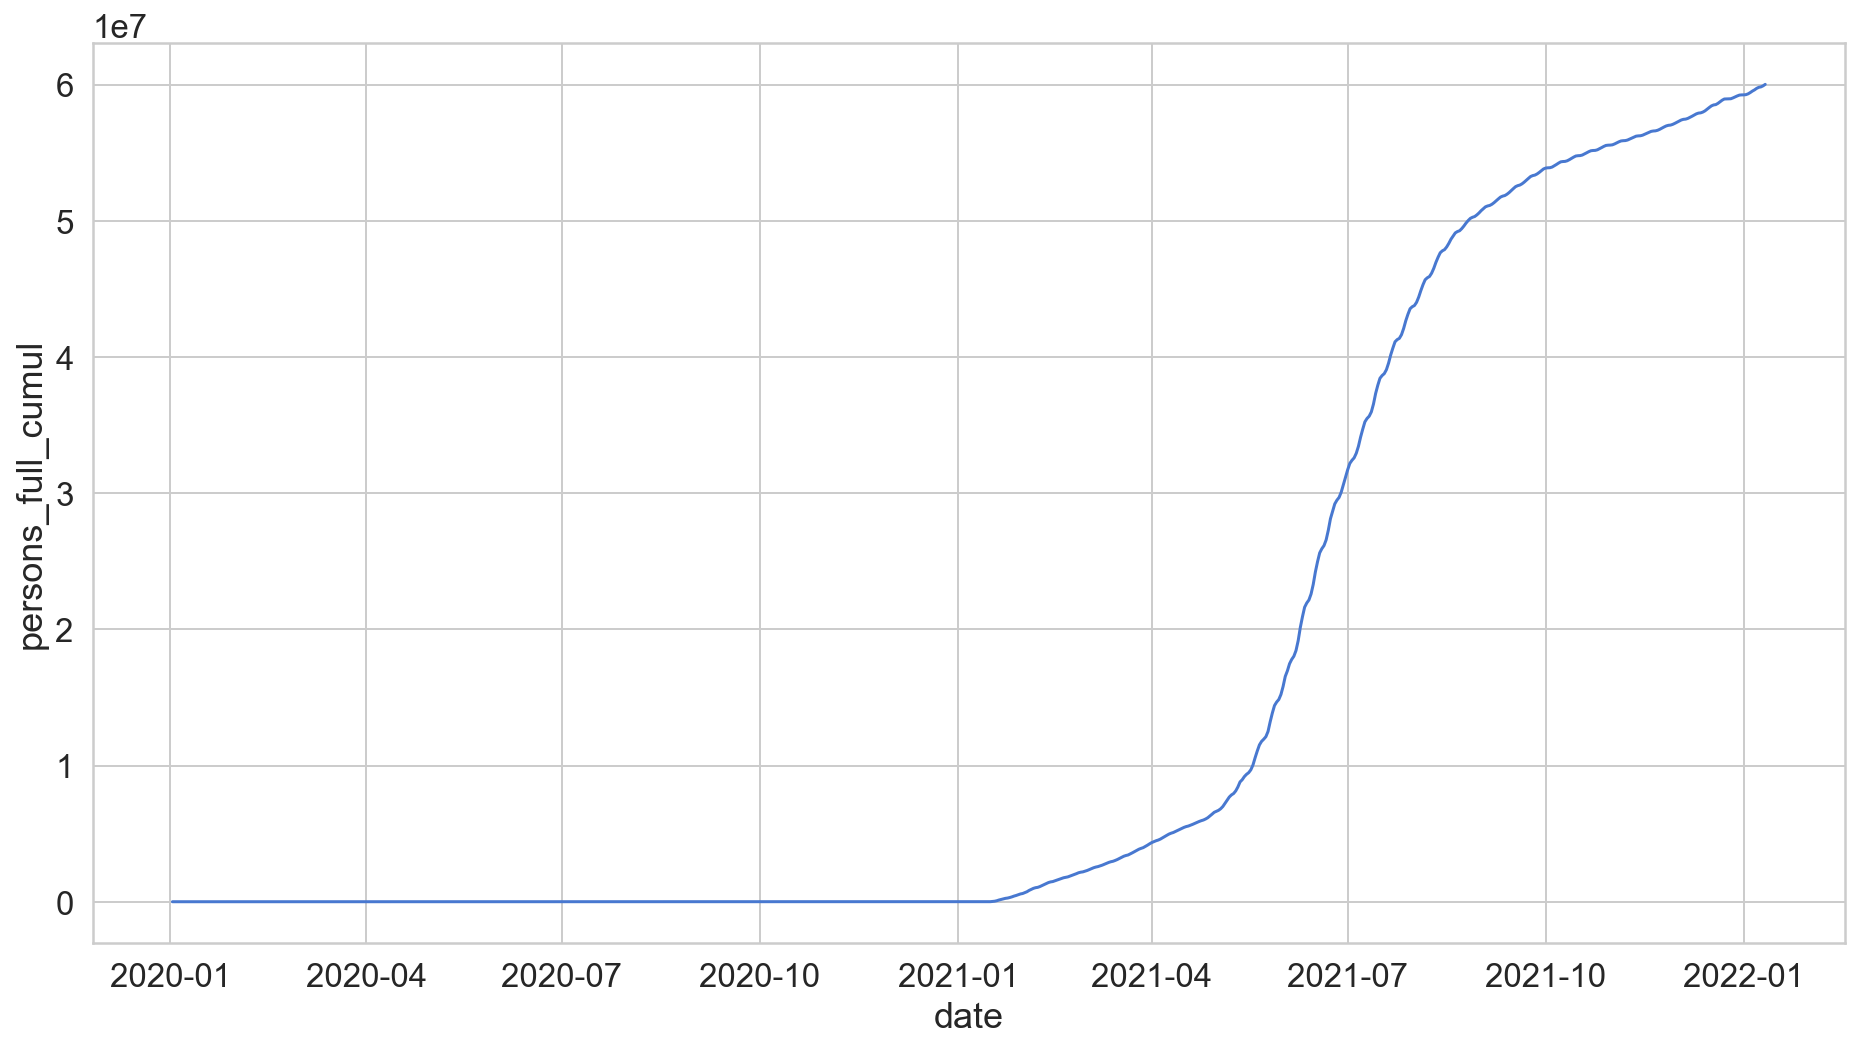

In [111]:
sns.lineplot(x=df.index, y="persons_full_cumul", data = df, sizes=100)

### Defining dates to be used for the forecasting, from 2020-12-29 to 2021-12-17 

In [119]:
#df['date'] = pd.date_range('2020-1-2', periods=661, freq='W')
#df = df.set_index(['date'])
df = (df.loc['2020-12-29':'2021-12-17'])

In [120]:
df

,deaths,cases,vacc_first_diff,persons_full_cumul,recovered
date,,,,,
2020-12-29,1246,27581,91698,727,26331
2020-12-30,1282,31056,155745,760,29762
2020-12-31,776,19589,205579,847,18805
2021-01-01,413,10273,231165,859,9853
2021-01-02,584,10014,279090,937,9418
...,...,...,...,...,...
2021-12-13,243,31548,2599635,57974962,31268
2021-12-14,316,60253,2585159,58063420,59851
2021-12-15,264,52408,2565437,58189415,52037


In [114]:
df.corr()

,deaths,cases,vacc_first_diff,persons_full_cumul,recovered
deaths,1.000000,0.526973,-0.463781,-0.333253,0.520190
cases,0.526973,1.000000,-0.349915,0.272930,0.996087
vacc_first_diff,-0.463781,-0.349915,1.000000,-0.209341,-0.344604
persons_full_cumul,-0.333253,0.272930,-0.209341,1.000000,0.273029
recovered,0.520190,0.996087,-0.344604,0.273029,1.000000


## __LSTM Forescating in TENSOR FLOW__

Introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections: 

* Forecast for a single time step:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

In [121]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.grid'] = False

In [122]:
df

,deaths,cases,vacc_first_diff,persons_full_cumul,recovered
date,,,,,
2020-12-29,1246,27581,91698,727,26331
2020-12-30,1282,31056,155745,760,29762
2020-12-31,776,19589,205579,847,18805
2021-01-01,413,10273,231165,859,9853
2021-01-02,584,10014,279090,937,9418
...,...,...,...,...,...
2021-12-13,243,31548,2599635,57974962,31268
2021-12-14,316,60253,2585159,58063420,59851
2021-12-15,264,52408,2565437,58189415,52037


Inspect and Cleanup

In [123]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
deaths,354.0,1.846299e+02,2.130875e+02,0.0,29.75,126.0,255.75,1282.0
cases,354.0,1.441792e+04,1.560976e+04,209.0,4085.00,9665.0,18020.25,75706.0
vacc_first_diff,354.0,7.072044e+06,6.642514e+06,91698.0,2278726.50,3788880.0,11594253.50,21918339.0
persons_full_cumul,354.0,2.803607e+07,2.299492e+07,727.0,3930228.25,28392059.0,52685210.25,58430005.0
recovered,354.0,1.412614e+04,1.535026e+04,207.0,3957.75,9478.5,17647.00,75225.0


In [124]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [125]:
df["day_of_week"] = df.index.day_of_week
df["day_of_month"] = df.index.day
df["month"] = df.index.month

<ipython-input-125-578b82ae1ea1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["day_of_week"] = df.index.day_of_week
<ipython-input-125-578b82ae1ea1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["day_of_month"] = df.index.day
<ipython-input-125-578b82ae1ea1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [129]:
df

,deaths,cases,vacc_first_diff,persons_full_cumul,recovered,day_of_week,day_of_month,month
date,,,,,,,,
2020-12-29,1246,27581,91698,727,26331,1,29,12
2020-12-30,1282,31056,155745,760,29762,2,30,12
2020-12-31,776,19589,205579,847,18805,3,31,12
2021-01-01,413,10273,231165,859,9853,4,1,1
2021-01-02,584,10014,279090,937,9418,5,2,1
...,...,...,...,...,...,...,...,...
2021-12-13,243,31548,2599635,57974962,31268,0,13,12
2021-12-14,316,60253,2585159,58063420,59851,1,14,12
2021-12-15,264,52408,2565437,58189415,52037,2,15,12


<AxesSubplot:xlabel='date', ylabel='deaths'>

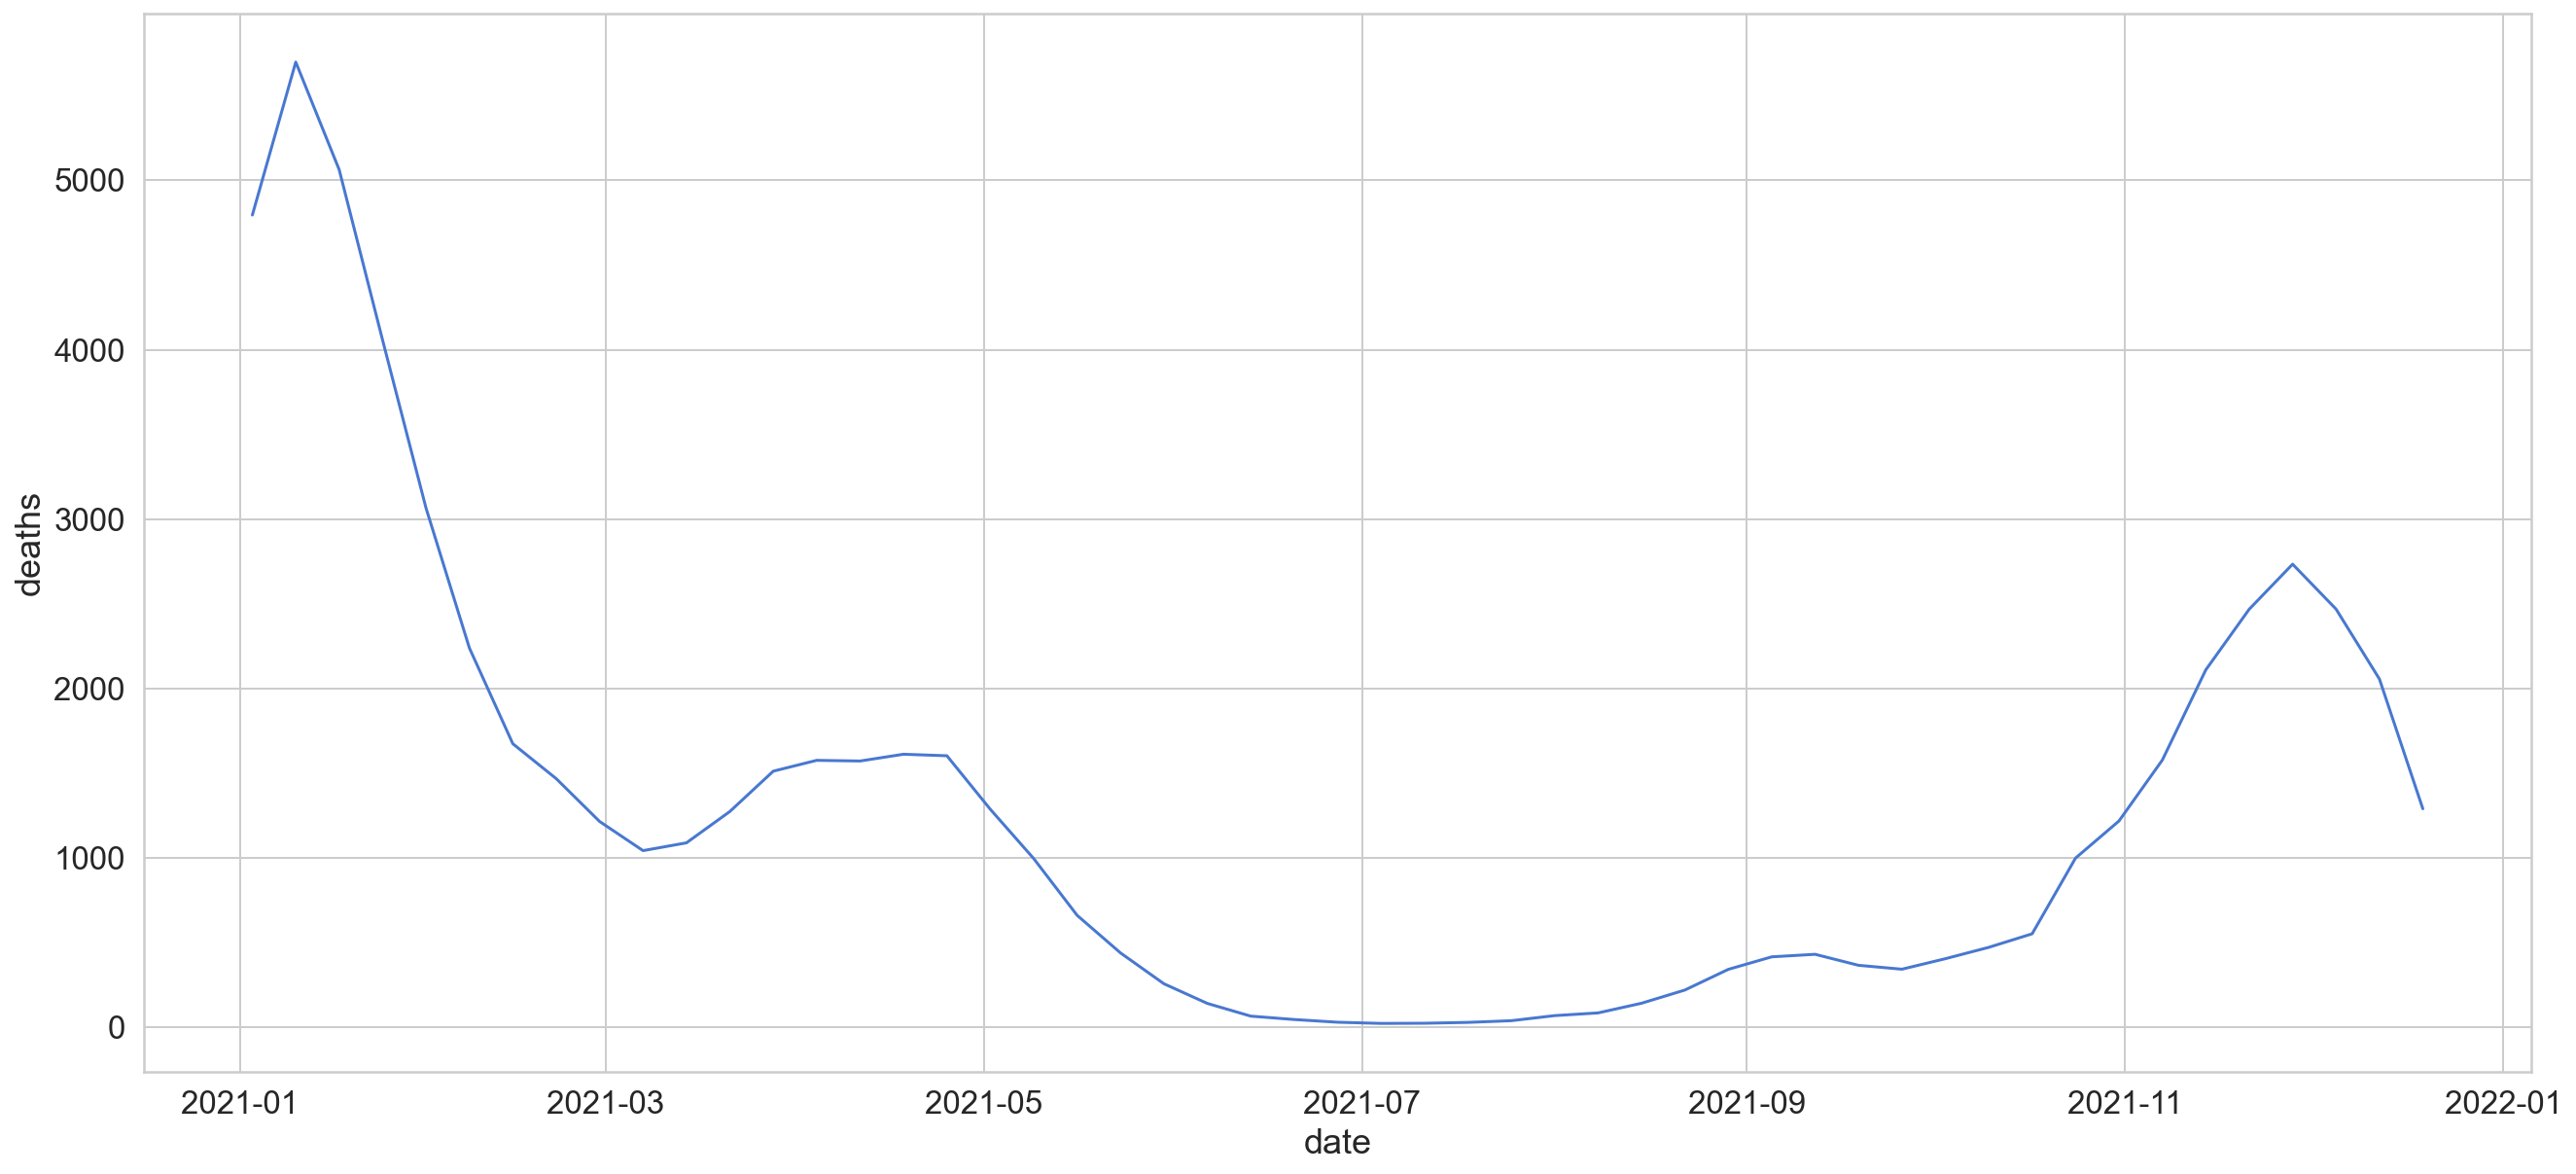

In [130]:
df_by_week = df.resample("W").sum()
sns.lineplot(x=df_by_week.index, y= "deaths", data = df_by_week)

### Data Splitting for model

In [131]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train = df.iloc[0:train_size]
test = df.iloc[train_size:len(df)]
print("train lenght:", len(train), "  test length:",len(test))

train lenght: 336   test length: 18


In [146]:
from sklearn.preprocessing import RobustScaler
feature_cols = ["cases", "vacc_first_diff", "persons_full_cumul", "recovered"]
target_col = ["deaths"]

feature_scaler = RobustScaler()
target_scaler = RobustScaler()

feature_scaler = feature_scaler.fit(train[feature_cols].to_numpy())
target_scaler = target_scaler.fit(train[target_col].to_numpy())

train.loc[:,feature_cols] = feature_scaler.transform(train[feature_cols].to_numpy())
train[target_col] = target_scaler.transform(train[target_col].to_numpy())

test.loc[:,feature_cols] = feature_scaler.transform(test[feature_cols].to_numpy())
test[target_col] = target_scaler.transform(test[target_col].to_numpy())

C:\Users\kev_i\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-146-cedea658fd3f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[target_col] = target_scaler.transform(train[target_col].to_numpy())
C:\Users\kev_i\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [147]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
num_features
df.columns

Index(['deaths', 'cases', 'vacc_first_diff', 'persons_full_cumul', 'recovered',
       'day_of_week', 'day_of_month', 'month'],
      dtype='object')

In [148]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

### Analyzing Distribution of important variables

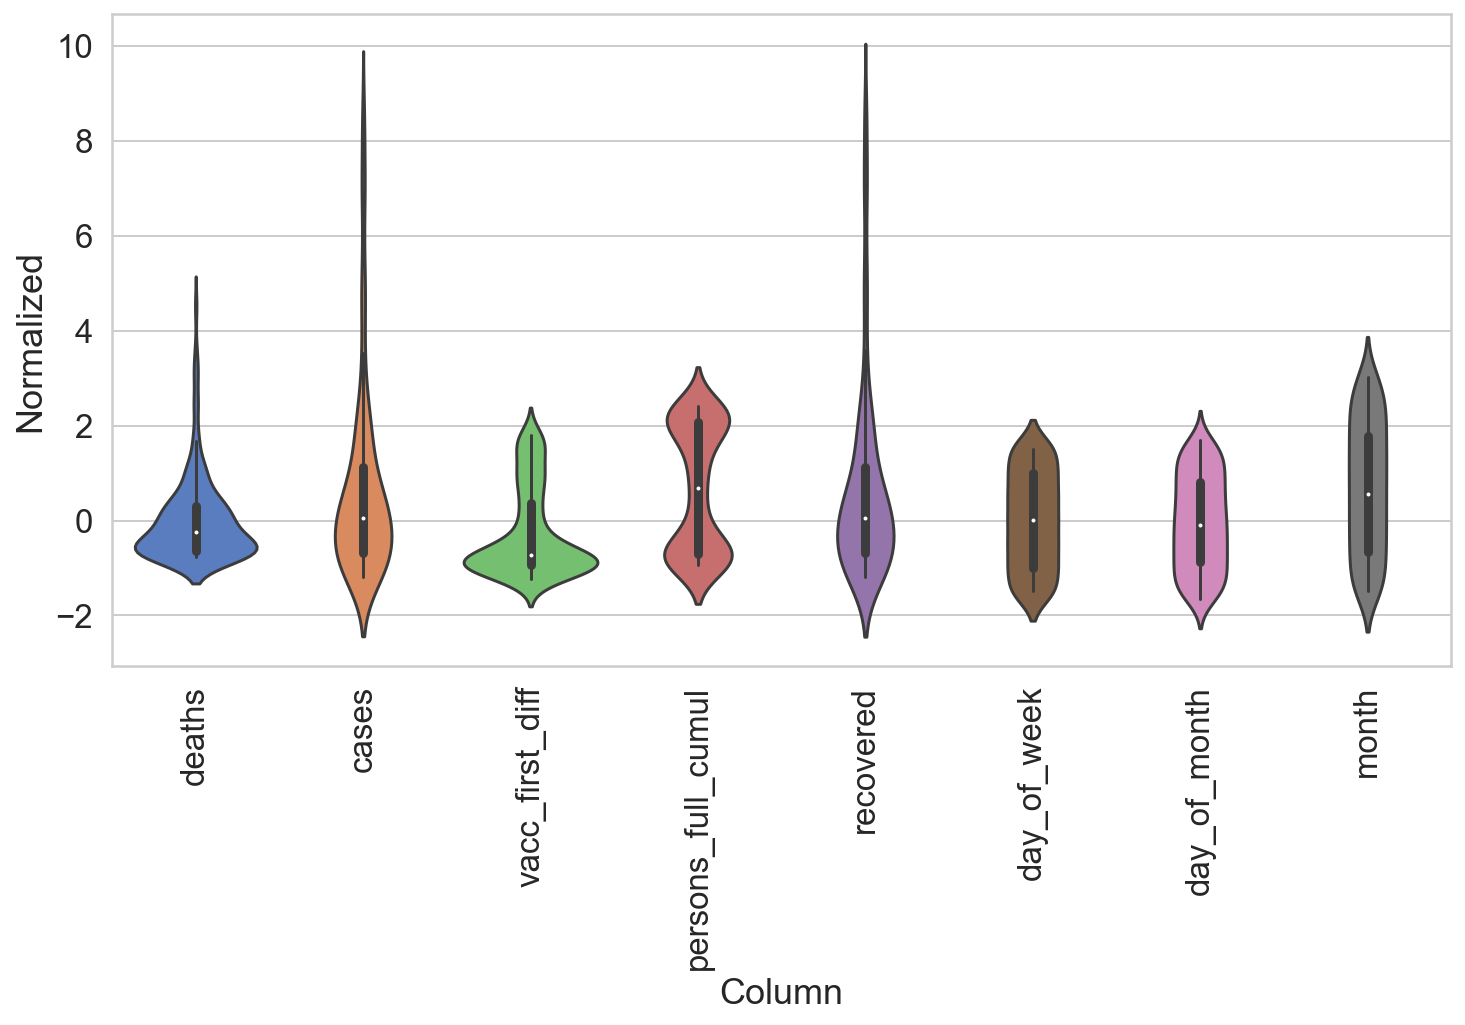

In [149]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [150]:
#Cut time sieries data into sequences
#amount of time we want to take as a history in our sequence
def create_dataset(X_features, y_target, time_steps = 10):
    Xs = []
    ys = []
    for i in range(len(X_features) - time_steps):
        v = X_features.iloc[i: (i + time_steps)].values
        Xs.append(v)
        ys.append(y_target.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [151]:
#how many days steps (days) back we will take a look at
time_steps = 7

X_train, y_train = create_dataset(train, train[target_col], time_steps)
X_test, y_test = create_dataset(test, test[target_col], time_steps)

#we will have, (datapoints, time steps history, features) and we are going to predict exactly the same number of training examples
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(329, 7, 8) (329, 1)
(11, 7, 8) (11, 1)


In [152]:
#bidirectional model not oly looks into the past but also into the future of the data
model = keras.Sequential()
model.add(
    #inside the bidirectional model we will have the LSTM
  keras.layers.Bidirectional(
    keras.layers.LSTM(
        #number of neurons
        #units=128,
        units = 255,
        #specify amount of inputs as it is our input layer
        #shape 1 is timesteps and shape 2 is features, from previous array
        input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
#dropout to regularize or penalize complex models, we can try different values or without it too, add rate or percent (.2 = 20%)
model.add(keras.layers.Dropout(rate=0.2))
#output one dense layer or fully connected layer, as it is regression we will oly output 1 neuron 
model.add(keras.layers.Dense(units=1))


In [153]:
#loss function
model.compile(loss='mean_squared_error', optimizer='adam')

In [154]:
history = model.fit(
    X_train, y_train, 
    #epochs is that the data in the training will be seen n times by our model, use n times in our model 
    #(with few epochs we can get good results, we can check the loss error change to see when it stops improving )
    epochs=30, 
    #batch the number of subsamples that the model will take when training from a single step
    batch_size=14, 
    #take some of the training data for the validation of our model, (percentage of data we will reserve)
    validation_split=0.1,
    #we dont want to shuffle as it is a time series data
    shuffle=False
)

Epoch 1/30
22/22 [==============================] - 8s 92ms/step - loss: 1.3435 - val_loss: 0.3866
Epoch 2/30
22/22 [==============================] - 1s 28ms/step - loss: 1.0031 - val_loss: 0.9756
Epoch 3/30
22/22 [==============================] - 1s 29ms/step - loss: 0.7268 - val_loss: 0.7031
Epoch 4/30
22/22 [==============================] - 1s 29ms/step - loss: 0.4505 - val_loss: 0.2238
Epoch 5/30
22/22 [==============================] - 1s 29ms/step - loss: 0.3189 - val_loss: 0.1590
Epoch 6/30
22/22 [==============================] - 1s 28ms/step - loss: 0.1797 - val_loss: 0.2031
Epoch 7/30
22/22 [==============================] - 1s 29ms/step - loss: 0.2236 - val_loss: 0.2329
Epoch 8/30
22/22 [==============================] - 1s 28ms/step - loss: 0.1769 - val_loss: 0.2089
Epoch 9/30
22/22 [==============================] - 1s 24ms/step - loss: 0.1299 - val_loss: 0.1809
Epoch 10/30
22/22 [==============================] - 0s 20ms/step - loss: 0.0965 - val_loss: 0.1529
Epoch 11/

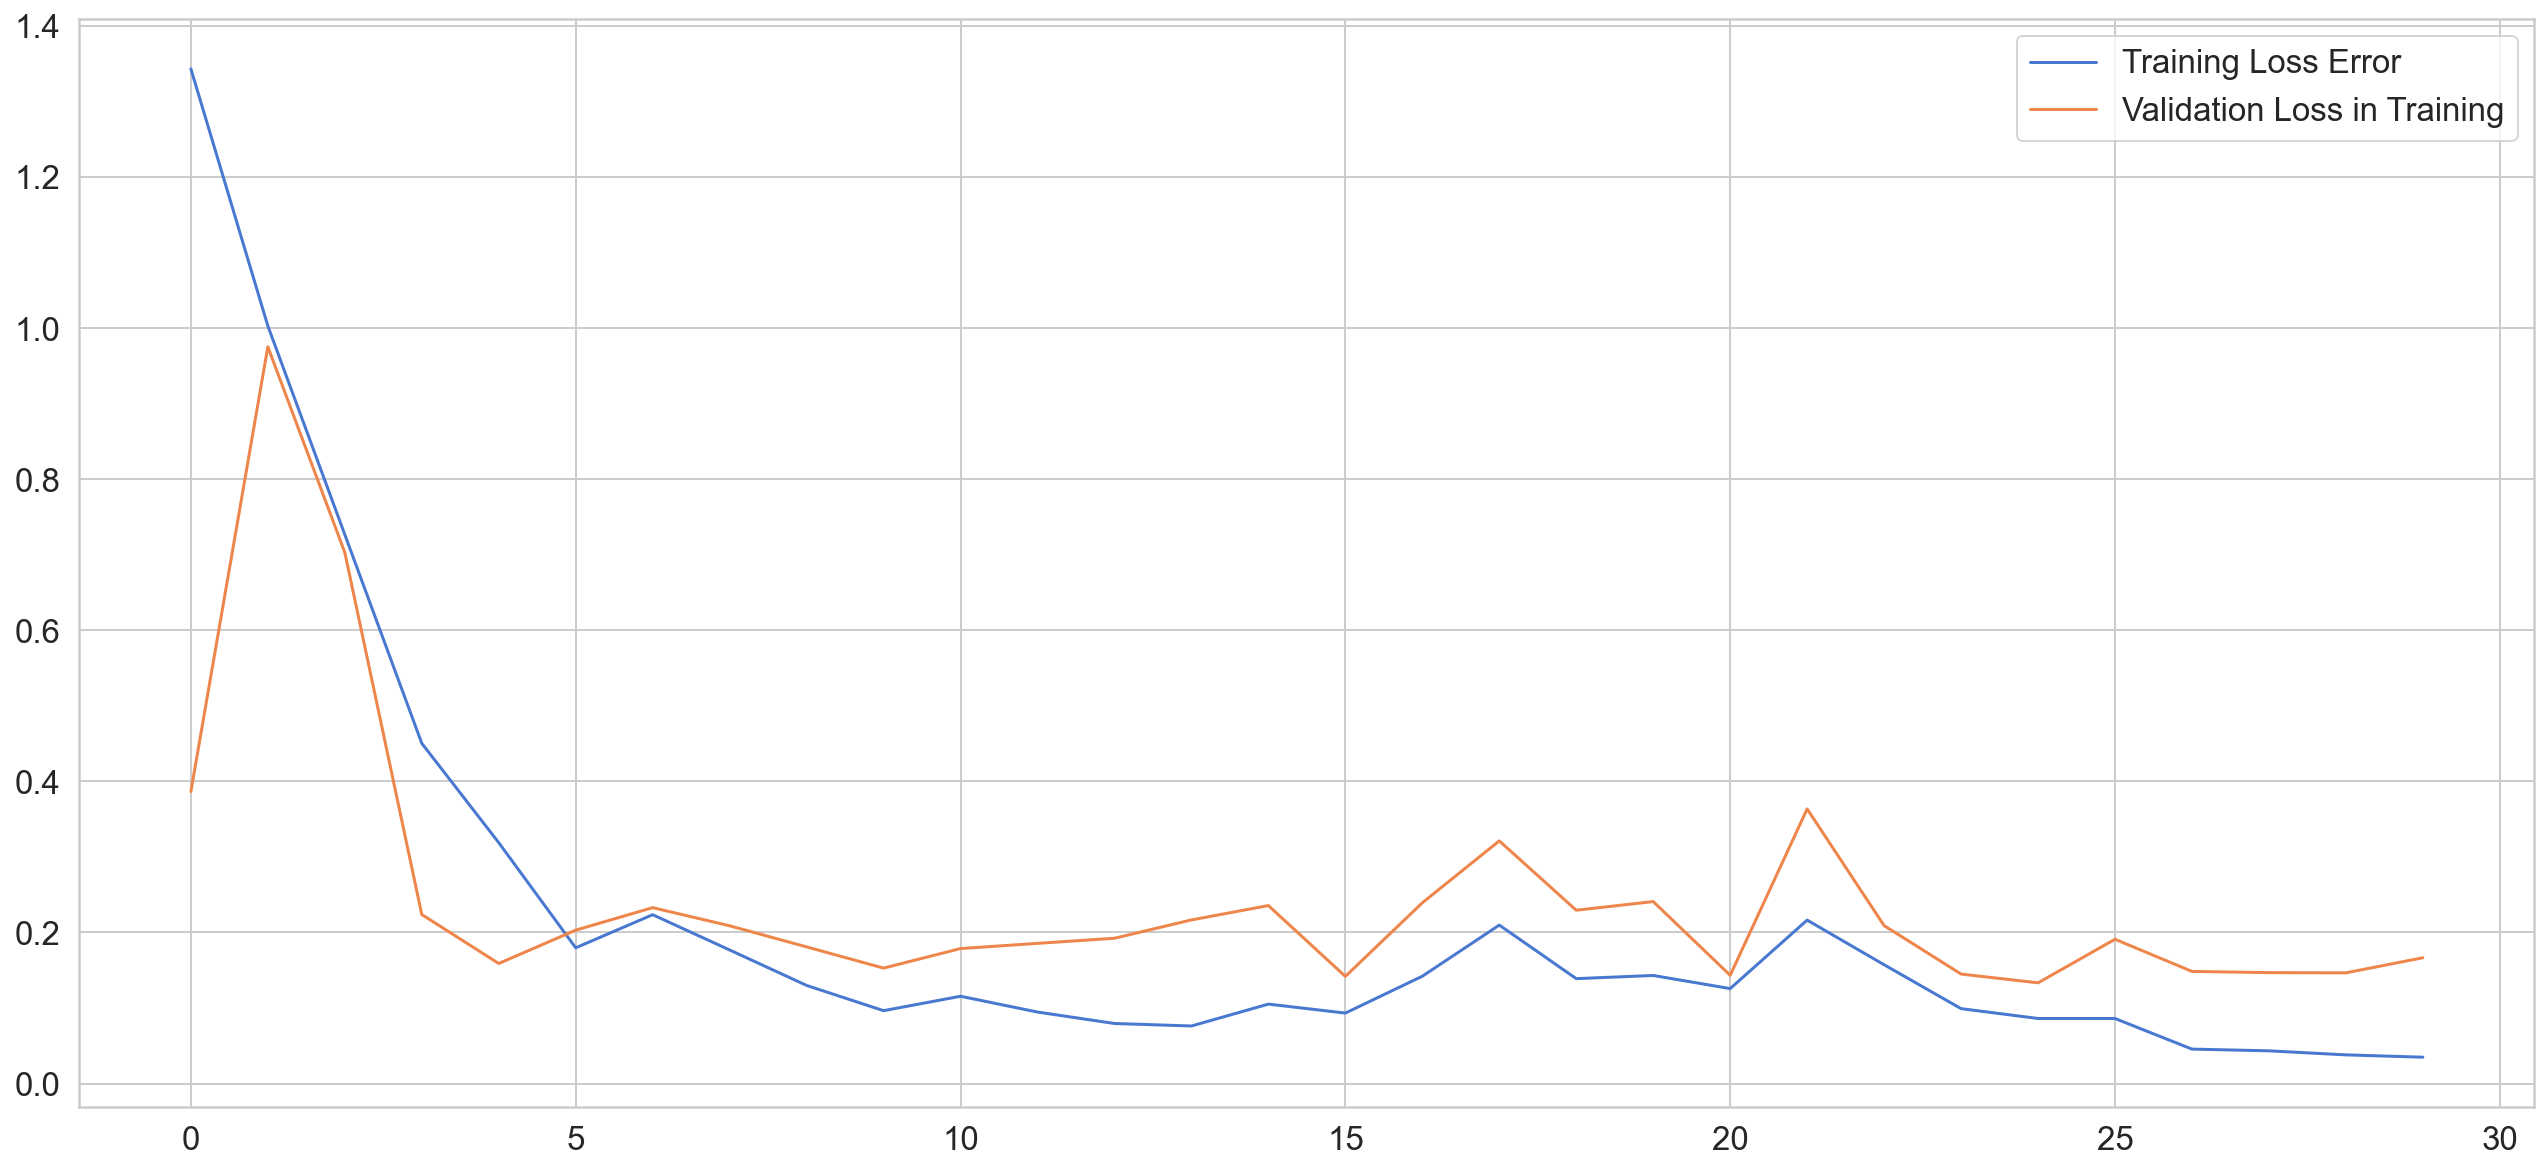

In [155]:
plt.plot(history.history["loss"], label="Training Loss Error")
plt.plot(history.history["val_loss"], label="Validation Loss in Training")
plt.legend();

In [156]:
y_pred = model.predict(X_test)

In [157]:
# we need to inverse the scaler we used to see the counts from the target variable
y_train_inv = target_scaler.inverse_transform(y_train.reshape(1, -1))
y_test_inv = target_scaler.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = target_scaler.inverse_transform(y_pred)

## Deaths Prediction

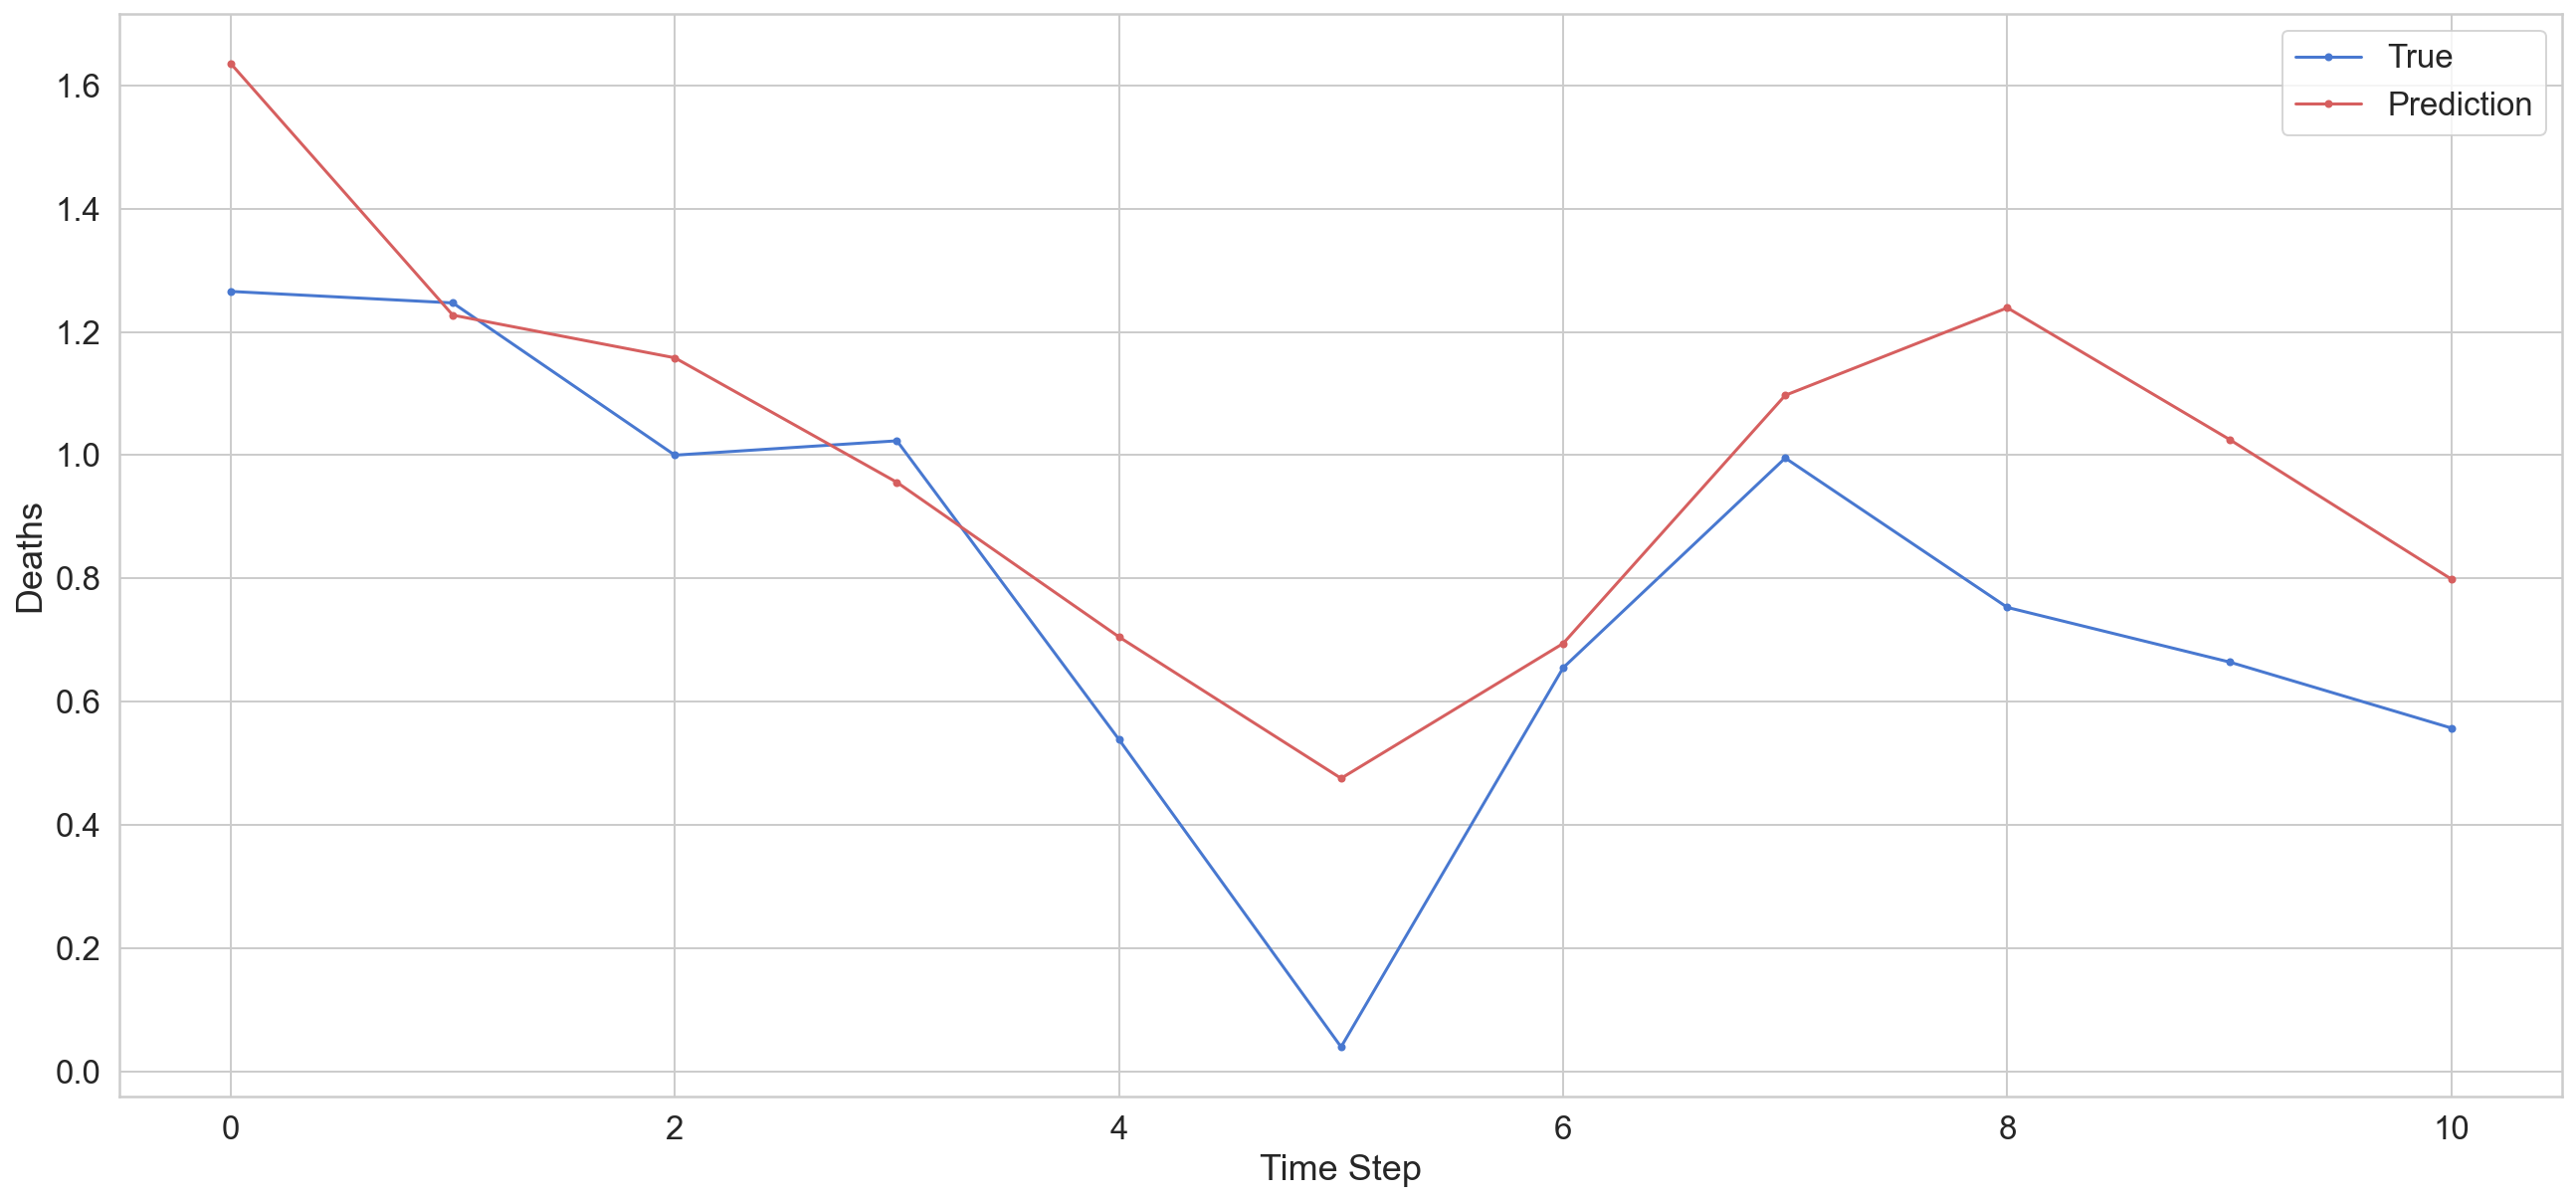

In [158]:
plt.plot(y_test_inv.flatten(), marker='.', label="True")
plt.plot(y_pred_inv.flatten(), 'r',  marker=".",  label="Prediction")
plt.ylabel('Deaths')
plt.xlabel('Time Step')
plt.legend()
plt.show();

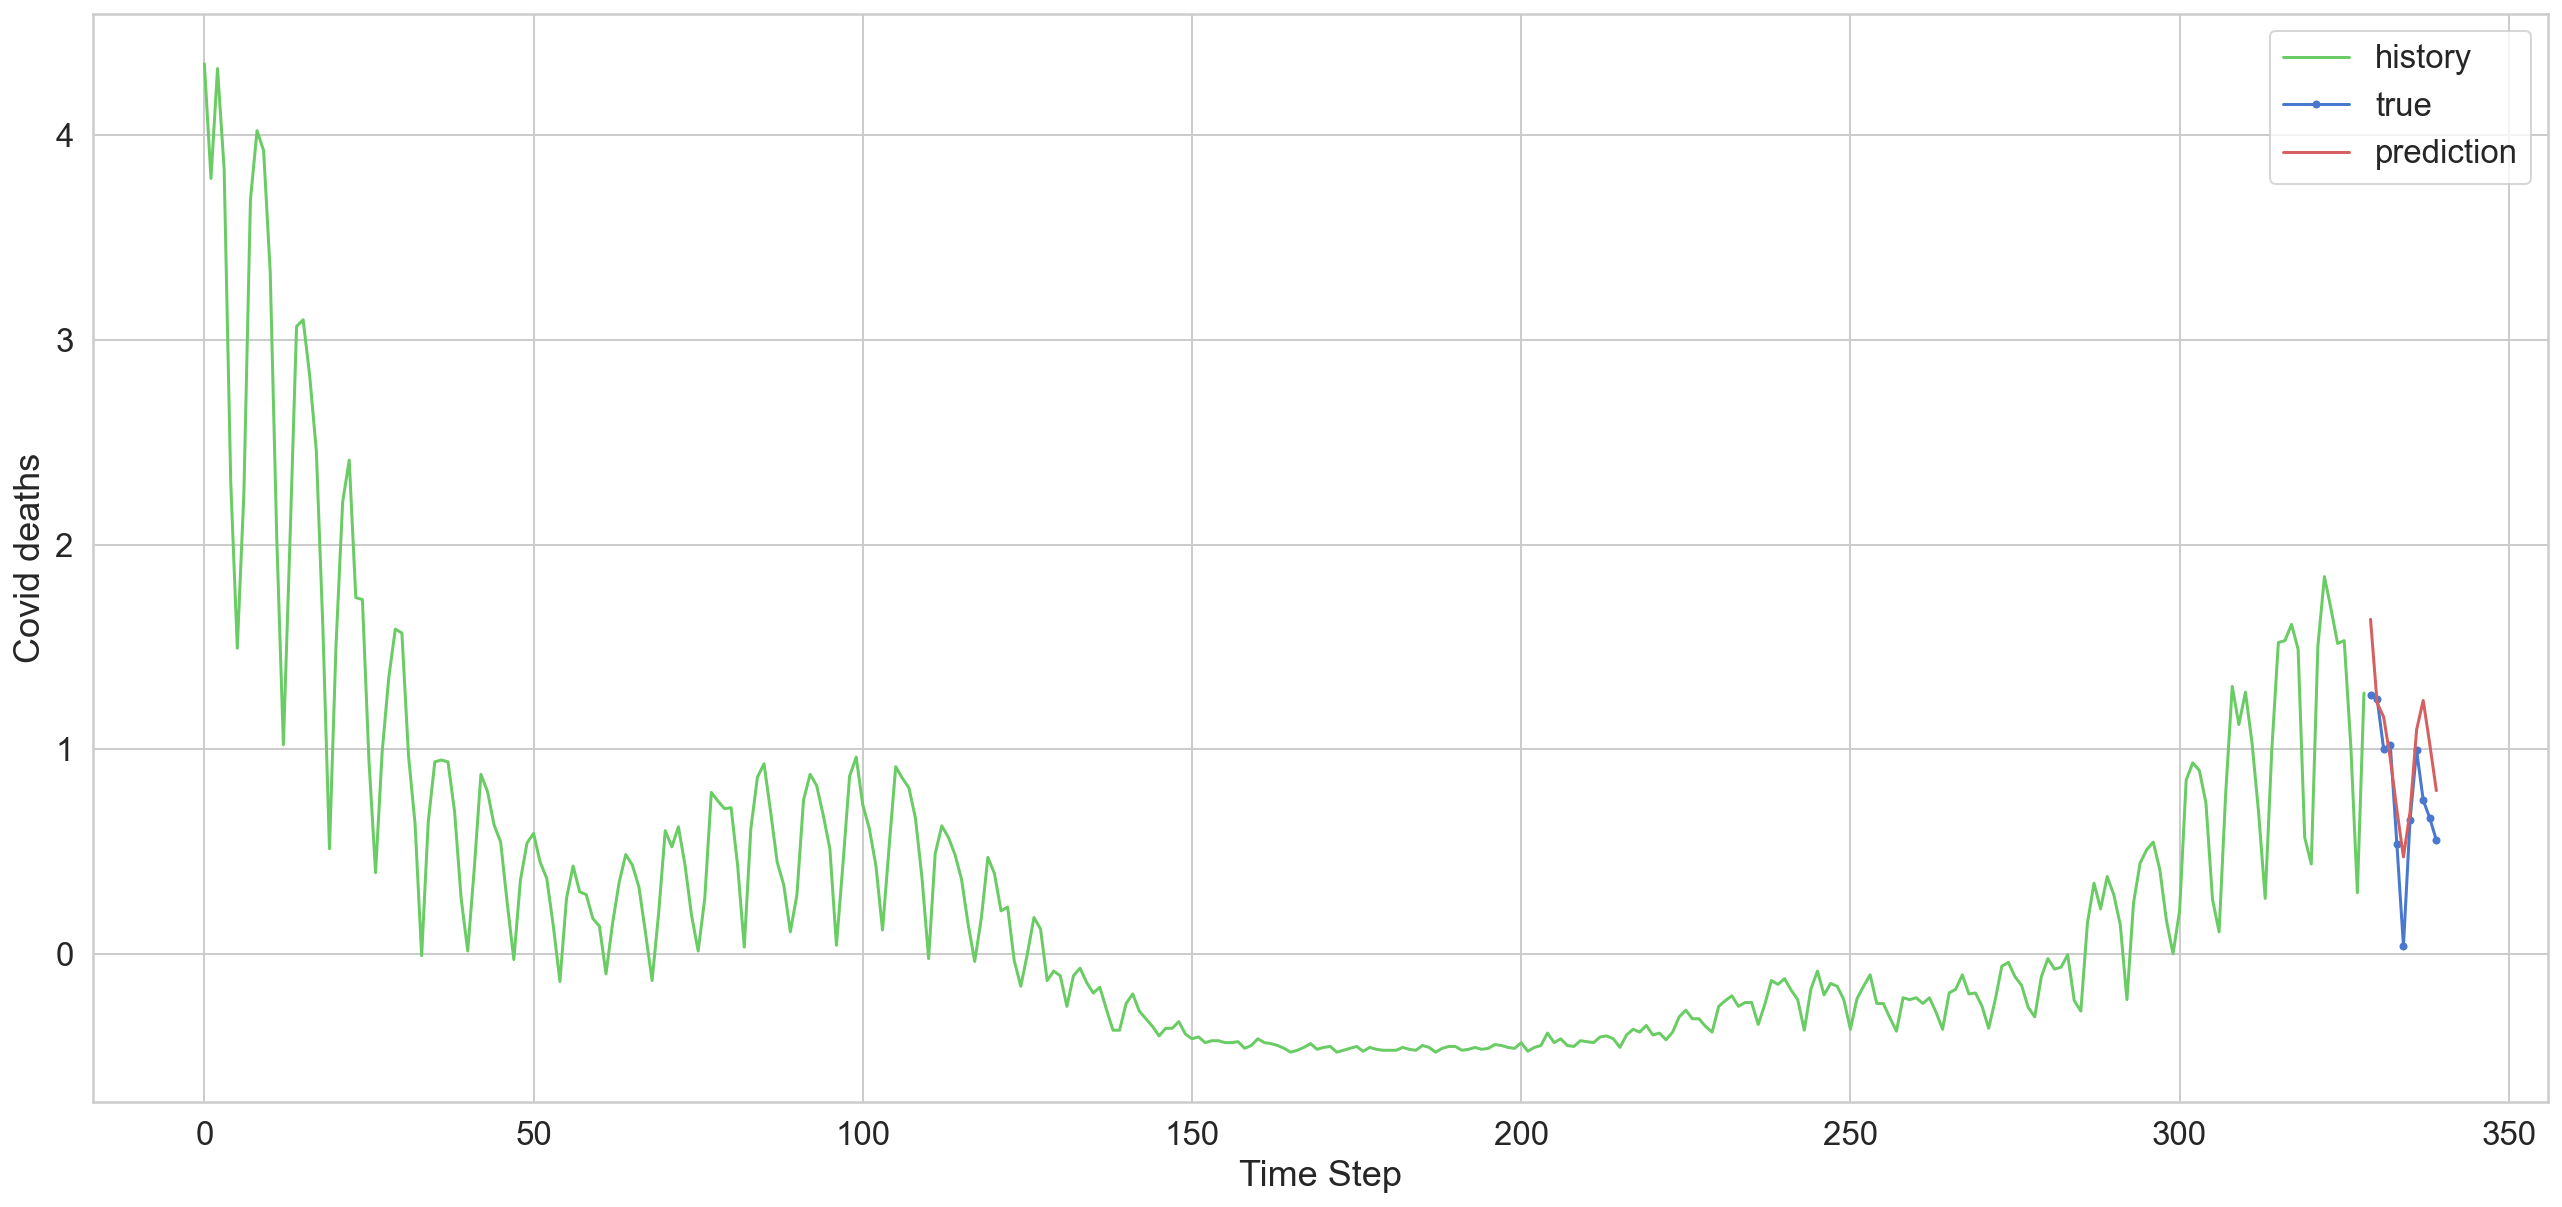

In [159]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Covid deaths')
plt.xlabel('Time Step')
plt.legend()
plt.show();